In [1]:
import torch
import torchaudio
from torchaudio import transforms

import matplotlib.pyplot as plt

import librosa

from pathlib import Path

from load import readAudio, readAnnotations
from convert_enst import ENST_MAPPING

In [2]:
def plot_data(data: torch.Tensor, label: torch.Tensor) -> None:
    fig, ax = plt.subplots(2)

    ax[0].set_title("Data (400 frames, 84 bins, 1 channel)")
    ax[0].imshow(data.squeeze().T)
    ax[0].set_xlabel("Frames (hop size: 10ms)")
    ax[0].set_ylabel("Frequency bins")
    ax[0].invert_yaxis()

    ax[1].set_title("Target (400 frames, 5 classes)")
    ax[1].imshow(label.squeeze().T.round(), aspect=10, interpolation="nearest")
    ax[1].set_xlabel("Frames (hop size: 10ms)")
    ax[1].set_ylabel("Classes")
    ax[1].set_yticks([0, 1, 2, 3, 4], ("BD", "SD", "TT", "HH", "CY+RD"))
    ax[1].invert_yaxis()

    fig.tight_layout()
    plt.show()

In [3]:
path = Path("../data/ENST-drums-public/drummer_1").resolve()
filename = "108_minus-one_rock-60s_sticks"

audio_path = (path / "audio" / "wet_mix" / filename).with_suffix(".wav")
accompaniment_path = (path / "audio" / "accompaniment" / filename).with_suffix(".wav")
annotation_path = (path / "annotation" / filename).with_suffix(".txt")

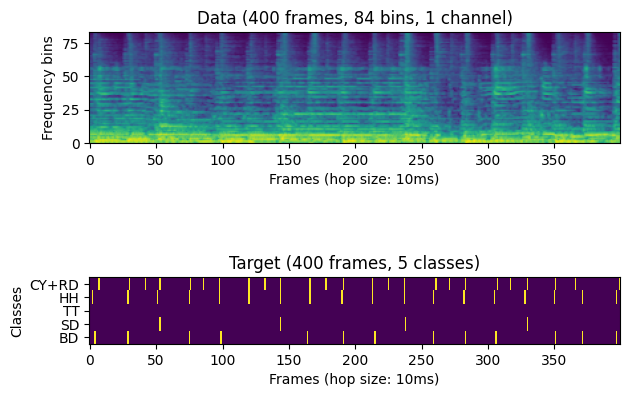

In [37]:
spectrogram = readAudio(audio_path, accompaniment_path)
timesteps = spectrogram.shape[0]
label = readAnnotations(annotation_path, ENST_MAPPING, timesteps, 5)

partitions = timesteps // 400

spectrograms = torch.stack(spectrogram.tensor_split(partitions, dim=0))
labels = torch.stack(label.tensor_split(partitions, dim=0))

plot_data(spectrograms[15], labels[15])

In [271]:
def plot_waveform(waveform: torch.tensor, sr: int = 22050, title: str = "") -> None:
    """Plot a given waveform"""
    librosa.display.waveshow(waveform.numpy(), sr=sr, alpha=0.5)
    plt.ylabel("Relative intensity")
    plt.title(title)

def plot_spectrogram(spectrogram: torch.tensor, hop_length: int, sr: int = 22050, title: str = "", y_axis: str = "linear", color_unit: str = "", ylabel: str = "") -> None:
    """Plot a spectrogram"""
    librosa.display.specshow(spectrogram.numpy(), sr=sr, hop_length=hop_length, x_axis="time", y_axis=y_axis)
    plt.colorbar(format="%+2.f " + color_unit)

    plt.title(title)
    if ylabel:
        plt.ylabel(ylabel)

waveform, sr = torchaudio.load(audio_path)
waveform = waveform.mean(dim=0)
spectrogram = transforms.MelSpectrogram(sample_rate=sr, n_fft=2048, win_length=2048, hop_length=441, n_mels=84, power=1)(waveform).T
print(spectrogram.shape)
print(labels.shape)
#plot_spectrogram(spectrogram, hop_length=2048, y_axis="linear")

#plot_data(spectrogram, labels)


torch.Size([7209, 84])
torch.Size([19, 400, 5])


In [333]:
waveform, sr = torchaudio.load(audio_path)
waveform = waveform.mean(dim=0)
spectrogram = transforms.MelSpectrogram(sample_rate=sr, n_fft=2048, win_length=2048, hop_length=441, n_mels=84, f_min=20, f_max=20000, norm="slaney", mel_scale="htk")(waveform)
spectrogram = torch.log10(1 + 1000*spectrogram)
#spectrogram = transforms.AmplitudeToDB()(spectrogram)
spectrogram = (spectrogram - spectrogram.min()) /  (spectrogram.max() - spectrogram.min())
spectrogram.pow(2)[0:400].sum(dim=1)

tensor([1230.8374, 3317.8809, 3774.8149, 2359.3789, 1556.5475, 1511.5503,
        1179.9102, 1115.0156, 1219.8713, 1048.1161,  808.4489,  870.6163,
         991.5486,  702.6967,  982.7894,  746.5521,  666.4987,  638.6921,
         455.7681,  364.6483,  377.3501,  451.8680,  384.7475,  441.0670,
         292.6424,  302.4343,  315.0590,  246.9588,  264.7969,  216.0819,
         178.5179,  193.8702,  241.6053,  236.9020,  203.9387,  168.4947,
         163.2148,  124.0757,  125.9606,  188.7283,  148.8862,  191.9543,
         227.1936,  155.6353,  155.6571,  150.0601,  161.1337,  224.3434,
         202.1877,  208.5795,  167.0056,  135.0766,  174.9867,  185.1847,
         222.2493,  205.2949,  157.9328,  186.8119,  210.7402,  168.0897,
         150.0739,  167.7211,  156.8482,  154.9698,  167.6312,  182.0998,
         180.1841,  176.9077,  167.1047,  145.3136,  160.2303,  162.0590,
         152.6805,  150.5077,  156.1586,  144.3588,  141.0042,  139.8501,
         117.3640,  114.7224,  126.266

In [332]:
torch.tensor(S)[0:400].pow(2).sum(dim=0)

tensor([ 23.2974,  93.8911, 118.7494,  65.3191,  59.3302,  79.6569,  50.6245,
         43.2448,  74.4643,  77.5408,  34.9188,  31.9790,  66.3309,  22.2024,
         45.0959,  29.7515,  26.8425,  18.0421,  13.8082,  10.2296,  14.8649,
         27.2436,  18.0969,  25.7991,  11.7980,  13.1805,  10.1676,   4.9009,
          5.7796,   5.6288,   4.4927,   5.8251,   7.2361,   6.5647,   4.1289,
          4.8098,   4.2510,   2.6423,   2.4639,   5.0173,   3.2991,   2.9858,
          3.4726,   2.8854,   2.3913,   2.2975,   1.8906,   2.3721,   2.3898,
          2.4322,   2.0377,   1.6763,   2.0172,   1.6045,   2.3863,   2.2054,
          1.8261,   1.4513,   1.6710,   1.6007,   1.2438,   1.3861,   0.9741,
          0.8297,   1.0153,   0.9738,   0.9144,   0.9637,   1.0048,   0.8136,
          0.8317,   0.6378,   0.6370,   0.6879,   0.6684,   0.7605,   0.6390,
          0.8056,   0.6031,   0.4924,   0.6629,   0.6047,   0.5751,   0.6246])

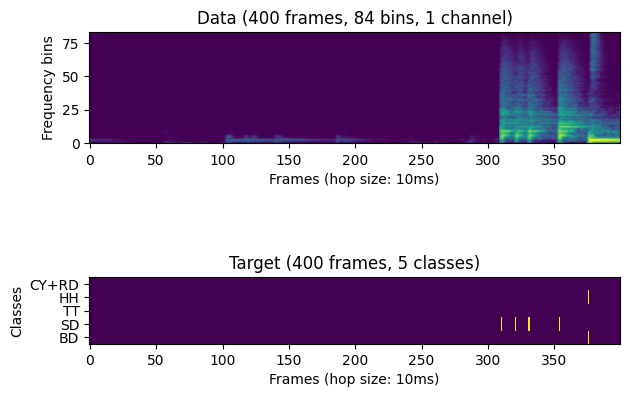

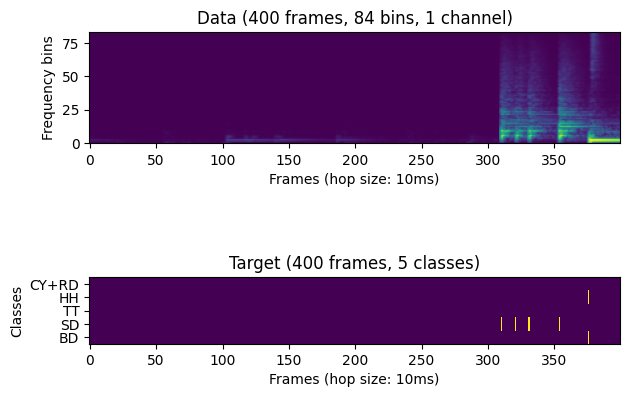

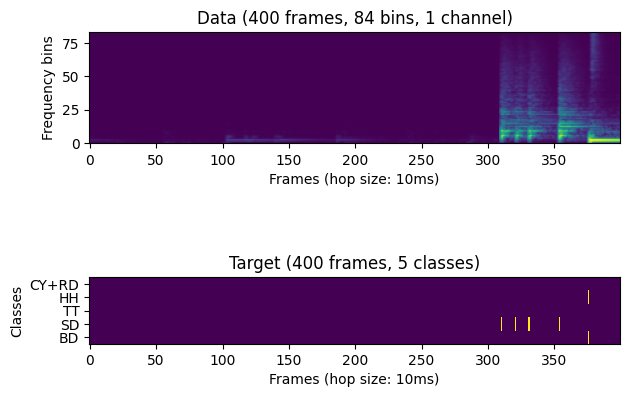

In [330]:
plot_data(spectrogram.T[0:400], label[0:400])
plot_data(S[0:400], label[0:400])
plot_data(S1[0:400], label[0:400])